# How to refine a correspondence with functional maps

This is the first demo on how to use geomfum to refine a correspondence. In this notebook we will see what does it mean and what are the main steps to do so. Lets Start!

# Importing shapes

In [2]:
from geomfum.shape import TriangleMesh
from geomfum.plot import MeshPlotter
from geomfum.dataset import NotebooksDataset
from geomfum.descriptor.pipeline import (
    ArangeSubsampler,
    DescriptorPipeline,
    L2InnerNormalizer,
)
from geomfum.descriptor.spectral import HeatKernelSignature, WaveKernelSignature
import numpy as np

from geomfum.functional_map import (
    FactorSum,
    LBCommutativityEnforcing,
    OperatorCommutativityEnforcing,
    SpectralDescriptorPreservation,
)
from geomfum.numerics.optimization import ScipyMinimize



We can visualize our shapes with the MeshPlotter

In [3]:
dataset = NotebooksDataset()

mesh_a = TriangleMesh.from_file(dataset.get_filename("cat-00"))
mesh_b = TriangleMesh.from_file(dataset.get_filename("lion-00"))


# Estimate intial functional map

In [7]:
#compute basis
mesh_a.laplacian.find_spectrum(spectrum_size=200, set_as_basis=True)
mesh_b.laplacian.find_spectrum(spectrum_size=200, set_as_basis=True)

mesh_a.landmark_indices =np.array( [2840, 1594,5596, 6809,3924,7169] )
mesh_b.landmark_indices =np.array( [1334,834,4136,4582,3666,4955])

# now we can compute the descriptrors
steps = [
    HeatKernelSignature.from_registry(n_domain=100, use_landmarks=True),
    ArangeSubsampler(subsample_step=1),
    L2InnerNormalizer(),
]

pipeline = DescriptorPipeline(steps)

descr_a = pipeline.apply(mesh_a)
descr_b = pipeline.apply(mesh_b)

#we select the number of eigenfunctions for our functional maps
mesh_a.basis.use_k=10
mesh_b.basis.use_k=10



In [18]:
from sklearn.neighbors import NearestNeighbors
from geomfum.convert import FmFromP2pConverter



nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(mesh_a.vertices)
distances, indices = nn.kneighbors(mesh_b.vertices)
p2p=indices.flatten()
converter= FmFromP2pConverter()
fmap=converter(p2p,mesh_a.basis,mesh_b.basis)

nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(mesh_b.vertices)
distances, indices = nn.kneighbors(mesh_a.vertices)
p2p21=indices.flatten()
converter= FmFromP2pConverter()
fmap12=converter(p2p21,mesh_b.basis,mesh_a.basis)

In certain cases, we want to estimate also the functional map in the other direction

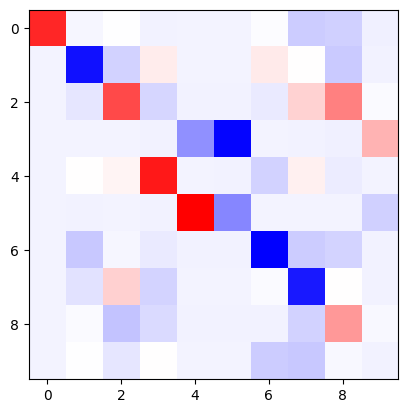

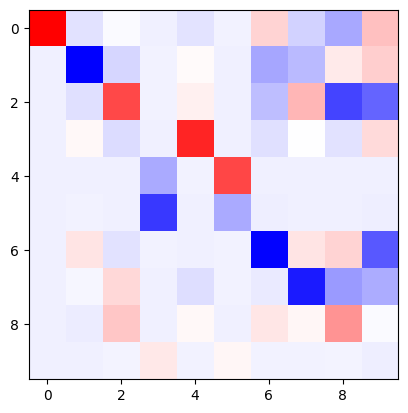

In [19]:
#we can visualize our functional map
import matplotlib.pyplot as plt
plt.imshow(fmap, cmap='bwr')
plt.show()
plt.imshow(fmap12, cmap='bwr')



# Refine the map


Once we estimated an initial functional maps, we can REFINE it. This mean that we want to perform a procedure to improve the quality of the correspondence obtained by the map, enforcing additional property to the map and (usually) augmenting the number of eigenfunctions used and the dimention of the functional map.
Over the years, a lot of methods have been proposed to perform this step of the pipeline, here we show different possible approaches

# ZoomOut

The ZoomOut algortihm has been one of the first approaches to perform 'spectral uspampling', which means increasing the number of eigenfunctions during refinement. Moreover, this algorithm is efficient and it produces orthogonal functional maps, which represent isometric correspondences.

In [20]:
from geomfum.refine import ZoomOut

In [21]:
zoomout = ZoomOut(nit=5, step=5)
zoomout_fmap_matrix_ = zoomout(fmap, mesh_a.basis, mesh_b.basis)

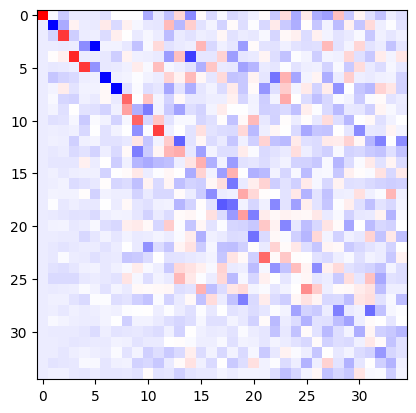

In [22]:
plt.imshow(zoomout_fmap_matrix_, cmap='bwr')

# Bijective ZoomOut

This algortihm produces bijective functional amps, leevraging them in both directions and looking for correspondences in a much larger space. It is a more constrained algorithm, and it is much expensive, but it can produce better correspondences.

In [13]:
from geomfum.refine import BijectiveZoomOut

In [14]:
bijective_zoomout = BijectiveZoomOut(nit=5, step=5)
bijective_zoomout_fmap_matrix_, bijective_zoomout_fmap_matrix_12  = bijective_zoomout(fmap,fmap12, mesh_a.basis, mesh_b.basis)

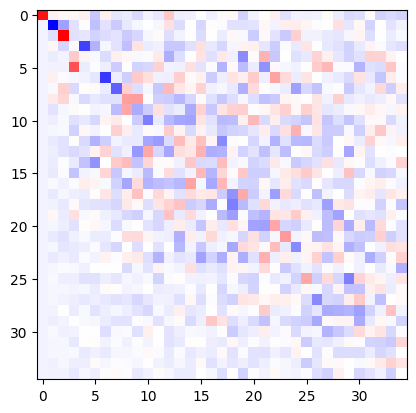

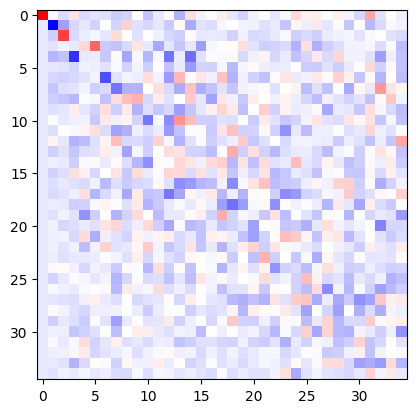

In [15]:
plt.imshow(bijective_zoomout_fmap_matrix_, cmap='bwr')
plt.show()
plt.imshow(bijective_zoomout_fmap_matrix_12, cmap='bwr')
plt.show()

# Fast Sinkhorn Filters

This algorithm is based on a different way of finding the correspondences given a functional map. Usually the conversion is performed via Nearest Search. This algorithm instead leverages Efficient optimal transport and retrieves the correspondence from an optimal transport map in the space of spectral emebddings

In [23]:
from geomfum.refine import FastSinkhornFilters

In [24]:
fsf = FastSinkhornFilters(nit=5, step=5)
sfs_fmap_matrix_ = fsf(fmap, mesh_a.basis, mesh_b.basis)

c:\USERS\GIULI\ONEDRIVE\RESEARCH\GEOMFUM_PROJ\VENV\Lib\site-packages\ot\bregman\_sinkhorn.py:631: RuntimeWarning: divide by zero encountered in divide
  v = b / KtransposeU
c:\USERS\GIULI\ONEDRIVE\RESEARCH\GEOMFUM_PROJ\VENV\Lib\site-packages\ot\bregman\_sinkhorn.py:631: RuntimeWarning: overflow encountered in divide
  v = b / KtransposeU
c:\USERS\GIULI\ONEDRIVE\RESEARCH\GEOMFUM_PROJ\VENV\Lib\site-packages\ot\bregman\_sinkhorn.py:643: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn("Warning: numerical errors at iteration %d" % ii)


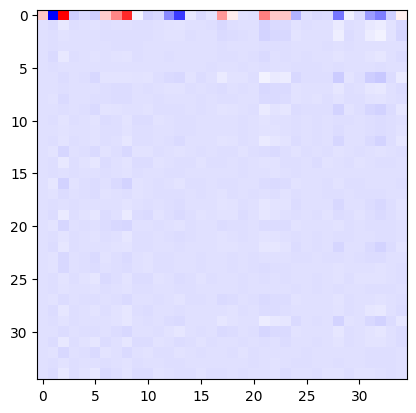

In [25]:
plt.imshow(sfs_fmap_matrix_, cmap='bwr')

# Adjoint Bijective ZoomOut

Adjoint Bijective ZoomOut is a recent algorithm which has been designed to work with any basis. It consider the conversion of a p2p into a adjoint operator.

In [26]:
from geomfum.refine import AdjointBijectiveZoomOut

In [27]:
abzo= AdjointBijectiveZoomOut(nit=5, step=5)
abzo_fmap_matrix_ = abzo(fmap, mesh_a.basis, mesh_b.basis)

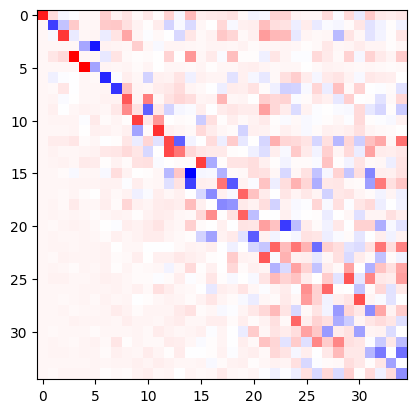

In [28]:
plt.imshow(abzo_fmap_matrix_, cmap='bwr')

# Discrete Optimization

This is a slightly different kind of refienement which serves as a new way of optimizing functional maps. We can consider different energies, some that takes into account also descriptors

In [29]:
from geomfum.refine import DiscreteOptimization

In [34]:
discr_opt = DiscreteOptimization(nit=5, step=5, energies=['ortho','descriptors'])
discr_opt_fmap_matrix_,discr_opt_fmap_matrix_12  = discr_opt(fmap,fmap12, mesh_a.basis, mesh_b.basis, descr_a, descr_b)

KeyboardInterrupt: 

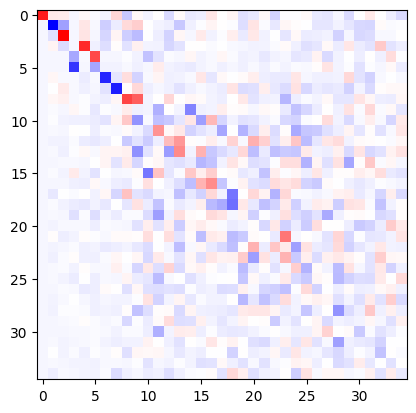

In [ ]:
plt.imshow(discr_opt_fmap_matrix_, cmap='bwr')

# SmoothFunctionalMaps

This refinement algorithm is base don a strategy that takes a lot from the previous discrete optimization, but improves it considering a smoothness energy on the displacement given by the permutation.

In [31]:
from geomfum.refine import SmoothOptimization
from geomfum.convert import DisplacementFromP2pConverter, P2pFromFmConverter

p2p_converter= P2pFromFmConverter()

p2p = p2p_converter(fmap, mesh_a.basis, mesh_b.basis)
p2p21 = p2p_converter(fmap12, mesh_b.basis, mesh_a.basis)

displacement_converter = DisplacementFromP2pConverter()
displacement21 = displacement_converter(p2p, mesh_a, mesh_b)
displacement12 = displacement_converter(p2p21, mesh_b, mesh_a)

In [32]:
smoothfm = SmoothOptimization(nit=5, step=5)
smooth_fmap_matrix_,smooth_fmap_matrix_12,smooth_displacement21, smooth_displacement12= smoothfm(fmap,fmap12,displacement21,displacement12, mesh_a, mesh_b)

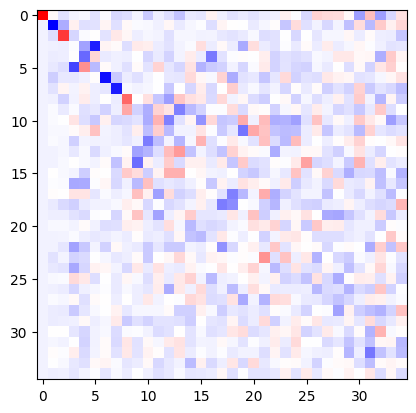

In [33]:
plt.imshow(smooth_fmap_matrix_, cmap='bwr')